In [1]:
#i = 0   #kalo udah bisa, iterasi 20_000 burn in 5_000
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import emcee
import corner
import math
import numdifftools as nd
import warnings
from IPython.display import display, Math
from scipy.integrate import odeint
from scipy.integrate import simpson
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.stats import norm
import scipy.constants as sc
from scipy.special import iv, kv
#matplotlib.rcParams['font.sans-serif'] = "cmr10"
#plt.rcParams['axes.unicode_minus'] = False
#matplotlib.rcParams['mathtext.fontset'] = "cm"

G = 4.2994e-6 # (km/s)**2 * kpc/Msun
H0 = 72 #km s^-1 Mpc^-1
delta_c = 200
h = H0/100
C = 1000  #Mpc to kpc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Data #i nya yang diubah
galaxy_data = pd.read_csv("C:/Users/student/Documents/Dante 20323002/MCMCdataobs.csv", index_col=0)
rc_data= pd.read_csv("C:/Users/student/Documents/Dante 20323002/MCMCrcobs.csv", index_col=0)
i = 17
ID = galaxy_data.iloc[i]['Galaxy']
galaxy = galaxy_data[galaxy_data.Galaxy == ID]
rc = rc_data[rc_data['ID'] == ID].reset_index(drop=True)
rad = rc['R']
Dobs = galaxy_data.iloc[i]['D']
Dobs_err = galaxy_data.iloc[i]['e_D']
incobs = galaxy_data.iloc[i]['Inc']
incobs_err = galaxy_data.iloc[i]['e_Inc']
Vobs = rc['Vobs']
Vobs_err = rc['e_Vobs']
Vdisk = rc['Vdisk']
Vgas = rc['Vgas']
Vmax = rc['Vobs'].max()
M_star_a = galaxy_data.iloc[i]['Mstar']
M_gas_a = 1.33* galaxy_data.iloc[i]['Mgas']
r_star = galaxy_data.iloc[i]['Rdisk']
r_gas = galaxy_data.iloc[i]['Rgas']
r_eff = galaxy_data.iloc[i]['Reff']
M_Ldisk_init = 0.5
Lstar = galaxy_data.iloc[i]['L']
print('ID = ',ID)
print('Npoint = ', len(rad))
print('Vmax = ',Vmax)
print('M/L_disk = '  , M_Ldisk_init)
print('inc = ',incobs)
print('inc_err = ',incobs_err)
print('D = ',Dobs)
print('D_err = ',Dobs_err)
print('Lstar = ',Lstar)

ID =  NGC6503
Npoint =  31
Vmax =  121.0
M/L_disk =  0.5
inc =  74.0
inc_err =  2.0
D =  6.26
D_err =  0.31
Lstar =  12845000000


In [4]:
#MCMC
def main(p0, nwalkers, niter, ndim, ln_posterior, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=data)

    print("Running burn-in...")
    p0 = sampler.run_mcmc(p0, 500, progress=True) #500 iterasi pertama ditetapkan sebagai burn-in
    sampler.reset() #reset sampler sebelum melakukan iterasi utama

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

In [5]:
sigma_m = 3 # cm^2/g
t_age = 10 # Gyr

rmin = rad[rad.idxmin()]
rmax = rad[rad.idxmax()]

dr = 0.001
r = []
rf = [] # full dari 0
rr = np.arange(rmin/10, rmax*3.5, dr)
for i in range(len(rr)):
    r2 = round(rr[i], 3)
    r.append(r2)
rr = np.arange(0, rmax*3.5, dr)
for i in range(len(rr)):
    r2 = round(rr[i], 3)
    rf.append(r2)
r = np.array(r)
rf = np.array(rf)
xnew = r[int(np.where(r == rmin)[0]):int(np.where(r == rmax)[0])+1]

def lnrhoiso(p, ra, sigmav0, Mb, dMb, dMb_drmax):
    lnrho_iso, omega = p
    if ra < rmin:
        rho_b = Mb[0]/(4*math.pi*(rmin**3)/3)
    elif rmin <= ra <= rmax:
        rho_b = dMb(ra)/(4*math.pi*(ra**2))
    else:
        rho_b = float(dMb_drmax)/(4*math.pi*(rmax**2)) * (rmax/ra)**4
    dlnrhodr = [omega, -4*math.pi*G*(rho_b + np.exp(lnrho_iso))/(sigmav0**2) - 2*omega/ra]
    return dlnrhodr

def VSIDM(logGam0, sigmav0, ML_d, rad, returnfig):
    # Profil massa barion
    Mb = []
    for i in range(len(rad)):
        mb = (ML_d*(Vdisk[i]**2) + Vgas[i]*np.abs(Vgas[i]))*rad[i]/G # Msun
        Mb.append(mb)
    
    # Interpolasi kuadratik
    Mb_f = interp1d(rad, Mb, kind='quadratic', bounds_error=False, fill_value='extrapolate')
    dMb = nd.Derivative(Mb_f, n=1)
    dMb_dr = dMb(r)

    # Profil densitas inti isotermal
    dMb_drmax = dMb_dr[np.where(r == rmax)]
    rho_0 = (10**logGam0)*(3.086e+21**2)*3.086e+16*np.sqrt(math.pi)/(sigma_m*1.989e+33*4*sigmav0*3.1536e+16*10) # Msun/kpc^3
    p0 = [np.log(rho_0), 0.0]
    
    sol = odeint(lnrhoiso, p0, r, args=(sigmav0, Mb, dMb, dMb_drmax))
    rho_iso = np.exp(sol[:,0])

    # Densitas dan radius transisi
    rho_t = rho_0/(t_age * 10**logGam0 / 10)
    r1 = round(np.interp(rho_t, np.flip(rho_iso), np.flip(r)), 3) # kpc

    # Menghitung rs dan rho_s
    y_iso = []
    a = 0
    
    for i in range(len(rf)):
        if rf[i] < r[0]:
            yiso = rf[i]**2 * rho_iso[0]
            y_iso.append(yiso)
        elif r[0] <= rf[i] <= r1:
            yiso = rf[i]**2 * rho_iso[a]
            a += 1
            y_iso.append(yiso)
        else: # r[i] > r1
            break

    A_iso = simpson(y_iso, rf[:int(np.where(rf == r1)[0])+1], even='avg')

    rs0 = 1.0 # initial
    drs = 1.0 # initial
    rs = 1.0 # initial
    rep = 0 # initial
    while drs > 0.001:
        rep += 1
        rs = r1/(np.exp(r1/(rs0+r1) + A_iso/(r1*rho_t*((rs0+r1)**2))) - 1) # revisi persamaan kontinuitas massa
        if math.isnan(rs):
            rs = np.inf
            break
        drs = np.abs(rs - rs0)
        rs0 = rs
        if rep == 100: # batas iterasi maksimum
            rs = np.inf
            break
    if np.isfinite(rs):
        rs = round(rs, 3) # kpc
        rho_s = rho_t*r1*((1 + r1/rs)**2)/rs
    else: # rs is infinite, break
        V_SIDM = np.array([0.0 for i in range(len(rad))])
        return V_SIDM

    # Kurva rotasi SIDM
    y_iso = []
    j = r[:int(np.where(r == r1)[0])+1]
    M_NFWdel = 4*math.pi*rho_s*(rs**3)*(np.log(1 + r1/rs) - r1/(rs + r1))

    V_SIDM = []
    k = 0
    for i in range(len(r)):
        if r[i] < r1:
            if r[i] > rmax:
                break
            yiso = r[i]**2 * rho_iso[i]
            y_iso.append(yiso)

            if r[i] == rad[k]:
                k += 1
                M_iso = 4*math.pi*simpson(y_iso, r[:int(np.where(r == r[i])[0])+1], even='avg')
                vsidm = np.sqrt(G*M_iso/r[i])
                V_SIDM.append(vsidm)
                #print(f"r: {r[i]}, rho_iso: {rho_iso[i]}, M_iso: {M_iso}, vsidm: {vsidm}")
        elif r[i] == r1: # revised, supaya M_iso yang digunakan di else adalah M_iso sampai r1
            if r[i] > rmax:
                break
            yiso = r[i]**2 * rho_iso[i]
            y_iso.append(yiso)
            M_iso = 4*math.pi*simpson(y_iso, j, even='avg')
            
            if r[i] == rad[k]:
                k += 1
                vsidm = np.sqrt(G*M_iso/r[i])
                V_SIDM.append(vsidm)
        else: # r[i] > r1
            if r[i] > rmax:
                break

            if r[i] == rad[k]:
                k += 1
                M_NFW = 4*math.pi*rho_s*(rs**3)*(np.log(1 + r[i]/rs) - r[i]/(rs + r[i])) - M_NFWdel
                vsidm = np.sqrt(G*(M_iso + M_NFW)/r[i])
                V_SIDM.append(vsidm)
    V_SIDM = np.array(V_SIDM)
    
    if returnfig == 1:
        # Profil Massa Baryon
        plt.figure(figsize=(9,6))
        plt.plot(rad, Mb, 'ko', xnew, Mb_f(xnew), 'r-')
        #plt.title(r'Profil Massa Baryon {} ($\sigma/m_{{\chi}} = 3\, \mathrm{{cm}}^2/\mathrm{{g}}$)'.format(df['ID'][0]), pad=10, size=20)
        #plt.xlim(0,)
        plt.yscale('log')
        plt.xscale('log', basex=10)

        plt.yticks(fontsize=12); plt.xticks(fontsize=12)
        plt.xlabel('Radius [kpc]', size=16)
        plt.ylabel(r'$M_{bar}$ [$M_{\odot}$]', size=16)
        plt.tight_layout()
        plt.grid(False)
        plt.savefig('Profil Massa Baryon SIDM {}.jpg'.format(rc['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        
        # Profil Densitas Baryon
        rho_b = []
        for i in range(len(r)):
            if r[i] < rad[0]:
                rhob = Mb[0]/(4*math.pi*(rad[0]**3)/3)
                rho_b.append(rhob)
            elif r[i] >= rad[0] and r[i] <= rmax:
                rhob = dMb_dr[i]/(4*math.pi*(r[i]**2))
                rho_b.append(rhob)
            else:
                rhob = float(dMb_drmax)/(4*math.pi*(rmax**2)) * (rmax/r[i])**4
                rho_b.append(rhob)
        rho_b = np.array(rho_b)
        
        plt.figure(figsize=(9,6))
        plt.plot(r, rho_b, label = r'$\rho_b$', c = "red", linewidth = 1.5, linestyle = 'solid')
        plt.axvline(rmin, c = "mediumorchid", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{min}$')
        plt.axvline(rmax, c = "orange", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{max}$')
        #plt.title(r'Profil Densitas Baryon {} ($\sigma/m_{{\chi}} = 3\, \mathrm{{cm}}^2/\mathrm{{g}}$)'.format(df['ID'][0]), pad=10, size=20)
        plt.xlabel('Radius [kpc]', size=16)
        plt.ylabel(r'$\rho_{bar}$ [$M_{\odot}/{kpc^3}$]', size=16)
        plt.yscale('log', basey=10); plt.xscale('log', basex=10)
        plt.xticks(fontsize=12); plt.yticks(fontsize=12)
        plt.legend(fontsize = 12)
        plt.tight_layout()
        plt.grid(False)
        plt.savefig('Profil Densitas Baryon SIDM {}.jpg'.format(rc['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        
        # Profil Densitas Isotermal
        plt.figure(figsize=(9,6))
        plt.plot(r, rho_iso, label = r'$\rho_{iso}$', c = "red", linewidth = 1.5, linestyle = 'solid')
        plt.axvline(rmin, c = "mediumorchid", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{min}$')
        plt.axvline(rmax, c = "orange", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{max}$')
        #plt.title(r'Profil Densitas Isotermal {} ($\sigma/m_{{\chi}} = 3\, \mathrm{{cm}}^2/\mathrm{{g}}$)'.format(df['ID'][0]), pad=10, size=20)
        plt.xlabel('Radius [kpc]', size=16)
        plt.ylabel(r'$\rho_{DM}$ [$M_{\odot}/{kpc^3}$]', size=16)
        plt.yscale('log', basey=10); plt.xscale('log', basex=10)
        plt.xticks(fontsize=12); plt.yticks(fontsize=12)
        plt.legend(fontsize = 12)
        plt.tight_layout()
        plt.grid(False)
        plt.savefig('Profil Densitas SIDM Iso {}.jpg'.format(rc['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        
        # Profil Densitas Iso & NFW
        rho_NFW = []
        for i in range(len(r)):
            rhonfw = rho_s/(r[i]/rs * (1 + r[i]/rs)**2)
            rho_NFW.append(rhonfw)
        
        plt.figure(figsize=(9,6))
        plt.plot(r, rho_iso, label = r'$\rho_{iso}$', c = "red", linewidth = 1.5, linestyle = 'solid')
        plt.plot(r, rho_NFW, label = r'$\rho_{NFW}$', c = "blue", linewidth = 1.5, linestyle = 'solid')
        plt.plot(r1, rho_t, 'ko')
        plt.axvline(r1, c = "black", linewidth = 1.0, linestyle = (5, (10, 3)), label=r'$r_1$')
        plt.axvline(rmin, c = "mediumorchid", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{min}$')
        plt.axvline(rmax, c = "orange", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{max}$')
        #plt.title('Profil Densitas Isotermal & NFW {} ($\sigma/m_{{\chi}} = 3\, \mathrm{{cm}}^2/\mathrm{{g}}$)'.format(df['ID'][0]), pad=10, size=20)
        plt.xlabel('Radius [kpc]', size=16)
        plt.ylabel(r'$\rho_{DM}$ [$M_{\odot}/{kpc^3}$]', size=16)
        plt.yscale('log', basey=10); plt.xscale('log', basex=10)
        plt.xticks(fontsize=12); plt.yticks(fontsize=12)
        plt.legend(fontsize = 12)
        plt.tight_layout()
        plt.grid(False)
        plt.savefig('Profil Densitas SIDM Iso NFW {}.jpg'.format(rc['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        
        # Profil Densitas SIDM
        rho_SIDM = []
        for i in range(len(r)):
            if r[i] <= r1:
                rho_SIDM.append(rho_iso[i])
            else: # r[i] > r1
                rho_SIDM.append(rho_NFW[i])

        plt.figure(figsize=(9,6))
        plt.plot(r, rho_SIDM, label = r'$\rho_{SIDM}$', c = "red", linewidth = 1.5, linestyle = 'solid')
        plt.plot(r1, rho_t, 'ko')
        plt.axvline(r1, c = "black", linewidth = 1.0, linestyle = (5, (10, 3)), label=r'$r_1$')
        plt.axvline(rmin, c = "mediumorchid", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{min}$')
        plt.axvline(rmax, c = "orange", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{max}$')
        #plt.title('Profil Densitas SIDM {} ($\sigma/m_{{\chi}} = 3\, \mathrm{{cm}}^2/\mathrm{{g}}$)'.format(df['ID'][0]), pad=10, size=20)
        plt.xlabel('Radius [kpc]', size=16)
        plt.ylabel(r'$\rho_{DM}$ [$M_{\odot}/{kpc^3}$]', size=16)
        plt.yscale('log', basey=10); plt.xscale('log', basex=10)
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        plt.legend(fontsize = 12)
        plt.tight_layout()
        plt.grid(False)
        plt.savefig('Profil Densitas DM SIDM {}.jpg'.format(rc['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        np.savetxt('profil densitas {} (SIDM).txt'.format(rc['ID'][0]), np.c_[r, rho_SIDM], fmt='% 1.3f', header='R     rho_SIDM')

        return rho_0, rho_t, r1, rs, rho_s
    else: # returnfig == 0
        return V_SIDM

#Fungsi model kecepatan rotasi total
def Vtot(ML_d, vDM, Vdisk, Vgas):
    return np.sqrt(vDM**2 + ML_d*(Vdisk**2) + Vgas*np.abs(Vgas))

In [6]:
#Likelihood
def ln_likelihood(theta, rad, Vobs, Vdisk, Vgas, Vobs_err):
    logGam0, sigmav0, ML_d = theta
    if logGam0 < np.log10(2) or logGam0 > 5.0 or sigmav0 < 2.0 or sigmav0 > 100.0 or ML_d < 0.0: # new
        lik = -np.inf
        return lik
    vDM = VSIDM(logGam0, sigmav0, ML_d, rad, 0)
    if np.sum(vDM) == 0.0:
        lik = -np.inf
        return lik
    else:
        vtot = Vtot(ML_d, vDM, Vdisk, Vgas)
        lik = np.sum(-np.log(np.sqrt(2*math.pi)*Vobs_err) - ((Vobs - vtot)**2)/(2*(Vobs_err**2)))
        return lik

#Prior
def ln_prior(theta):
    logGam0, sigmav0, ML_d = theta
    if np.log10(2) < logGam0 < 3.0: # (10 Gyr)^-1
        p1 = 1/(3 - np.log10(2))
    else:
        p1 = 0.0
    if 2.0 < sigmav0 < 150.0: # km/s
        p2 = 1/148
    else:
        p2 = 0.0
    if ML_d > 0.0:
        p3 = norm.pdf(x=ML_d, loc=0.5, scale=(10**0.1 - 1))
    else:
        p3 = 0.0
    return np.log(p1*p2*p3)

#Posterior = (Likelihood * Prior)/Evidence
def ln_posterior(theta, rad, Vobs, Vdisk, Vgas, Vobs_err):
    lp = ln_prior(theta)
    ll = ln_likelihood(theta, rad, Vobs, Vdisk, Vgas, Vobs_err)
    if (not np.isfinite(lp)) or (not np.isfinite(ll)):
        return -np.inf
    else:
        return lp + ll

In [7]:
#Menjalankan MCMC
nwalkers = 25 #number of walkers
niter = 7500 #number of iterations
init_param = np.array([1.342, 33.3, 0.49]) #logGam0, sigmav0, M/L ambil semuanya secara sembarang dalam rentang prior
ndim = len(init_param) #number of dimension
p0 = [np.array(init_param) + np.array(init_param)*1e-7*np.random.normal(size=np.array(init_param).size) for i in range(nwalkers)] #methodology of stepping from one place to a grid to the next
 
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,ln_posterior,(rad, Vobs, Vdisk, Vgas, Vobs_err)) #run MCMC

Running burn-in...


100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [11:21:18<00:00, 81.76s/it]


Running production...


100%|██████████████████████████████████████████████████████████████████████████| 7500/7500 [162:06:01<00:00, 77.81s/it]


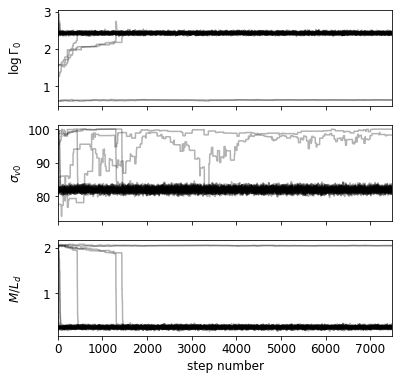

In [8]:
#Membuat plot masing-masing parameter (MCMC chains) untuk mengecek konvergensi
fig, axes = plt.subplots(ndim, figsize=(6, 6), sharex=True)
samples = sampler.get_chain()
labels = [r"$\log\,\Gamma_0$", r"$\sigma_{v0}$", r"$M/L_d$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.tick_params(axis="x", labelsize=12) # new
    ax.tick_params(axis="y", labelsize=12) # new
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=12)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontsize=12);
plt.savefig('Trace plot {} (SIDM).jpg'.format(rc['ID'][0]), bbox_inches = 'tight', dpi=200)

In [9]:
# Flat: concatenating the samples from each walker in the chain
# Discard: menghapus X sampel (flattened) pertama
# Thin: mengambil sampel kelipatan ke-X saja (untuk merampingkan sampel dan menghemat ukuran sampel)
flat_samples = sampler.get_chain(thin=5, flat=True)
np.savetxt("Flat samples {} (SIDM).txt".format(rc['ID'][0]), np.c_[flat_samples[:, 0],flat_samples[:, 1],flat_samples[:, 2]])
print("Mean autocorrelation time (SIDM): {0:.3f}".format(np.mean(sampler.get_autocorr_time())))

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 150;
tau: [156.3607573  203.31030902 191.92562528]

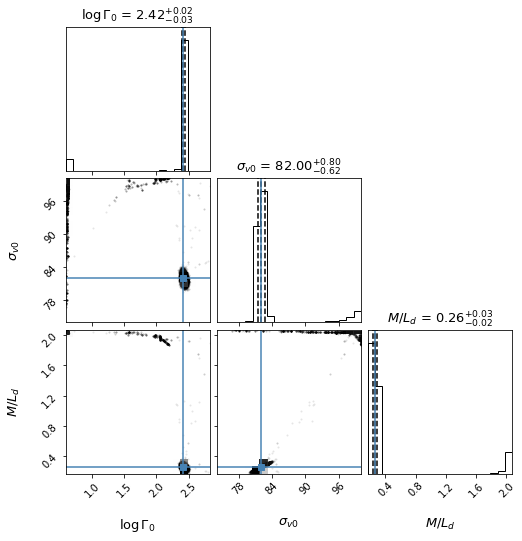

In [10]:
#Membuat corner plot
#Menyimpan nilai best-fit parameter hasil MCMC
flat_samples = np.loadtxt("Flat samples {} (SIDM).txt".format(rc['ID'][0]))
labels = [r"$\log\,\Gamma_0$", r"$\sigma_{v0}$", r"$M/L_d$"]
logGam0 = np.median(flat_samples[:, 0])
sigmav0 = np.median(flat_samples[:, 1])
ML_d = np.median(flat_samples[:, 2])

fig = corner.corner(flat_samples,show_titles=True,title_kwargs={"fontsize":13},labels=labels,label_kwargs={"fontsize":13},plot_datapoints=True,truths=[logGam0,sigmav0, ML_d],quantiles=[0.16, 0.5, 0.84],dpi=200)
plt.savefig('Corner plot {} (SIDM).jpg'.format(rc['ID'][0]), bbox_inches = 'tight', dpi=200)

In [11]:
#Menghitung kecepatan komponen halo DM dan kecepatan total menggunakan nilai best-fit
vDM = VSIDM(logGam0, sigmav0, ML_d, rad, 0)
vtot = Vtot(ML_d, vDM, Vdisk, Vgas)

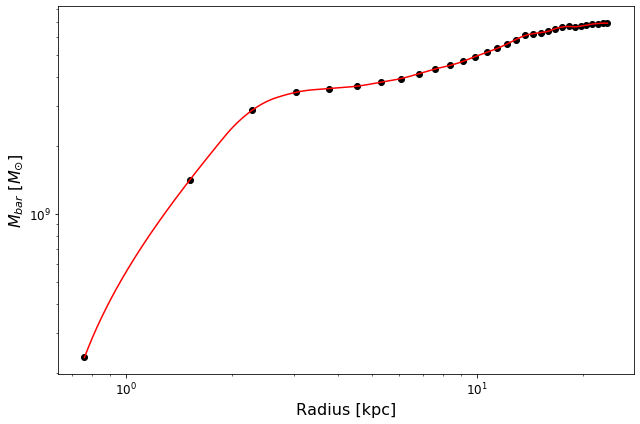

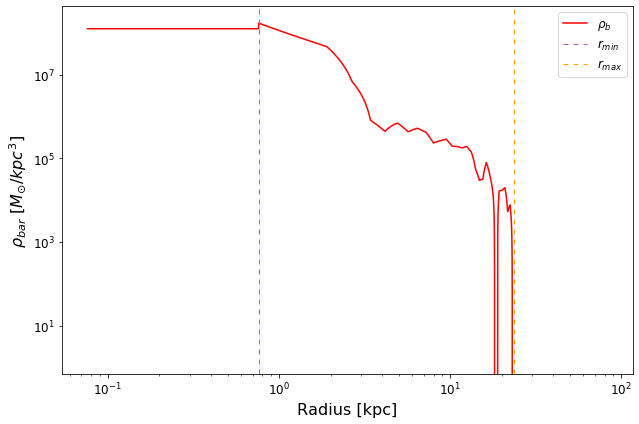

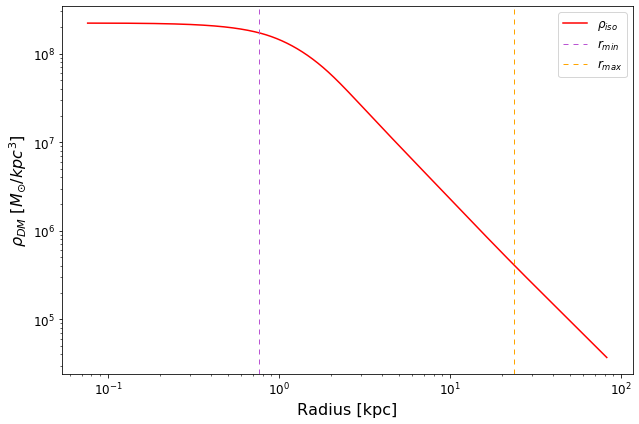

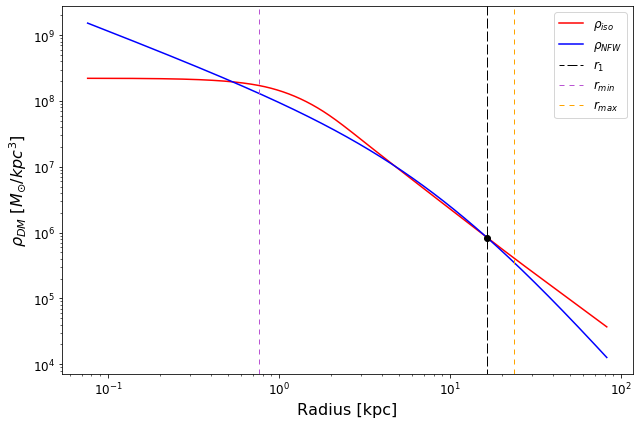

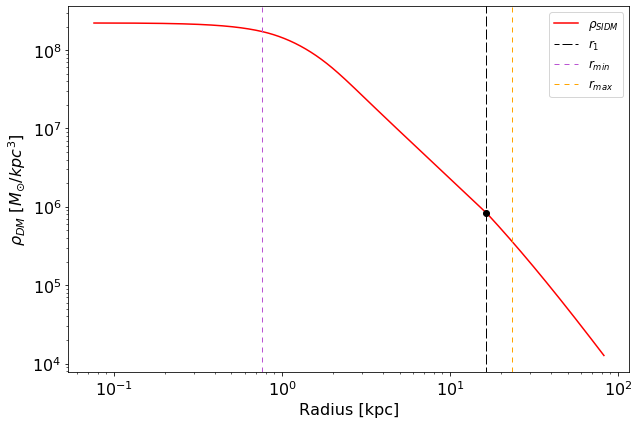

In [12]:
# Menampilkan seluruh plot yang dibuat dalam proses menurunkan kurva rotasi SIDM dan menyimpan nilai rho_0, rho_t, r1, rs, dan rho_s
rho_0, rho_t, r1, rs, rho_s = VSIDM(logGam0, sigmav0, ML_d, rad, 1)

In [13]:
# Menuliskan nilai best-fit parameter hasil MCMC dan reduced chi squared
labels2 = [r'\log\,\Gamma_0', r'\sigma_{v0}', r'M/L_d']
ndim = 3
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels2[i])
    display(Math(txt))

# Menuliskan rho_0, rho_t, r1, rs, dan rho_s
trho_0 = "\mathrm \\rho_0 = {0:.3f} \, M_{{\odot}}/\\textrm{{kpc}}^3".format(rho_0)
trho_t = "\mathrm \\rho(r_1) = {0:.3f} \, M_{{\odot}}/\\textrm{{kpc}}^3".format(rho_t)
tr1 = "\mathrm r_{{1}} = {0:.3f} \, \\textrm{{kpc}}".format(r1)
trs = "\mathrm r_{{s}} = {0:.3f} \, \\textrm{{kpc}}".format(rs)
trho_s = "\mathrm \\rho_{{s}} = {0:.3f} \, M_{{\odot}}/\\textrm{{kpc}}^3".format(rho_s)
display(Math(trho_0))
display(Math(trho_t))
display(Math(tr1))
display(Math(trs))
display(Math(trho_s))

chisq = 0.
for i in range(len(rad)):
    chisq = chisq + (((Vobs[i] - vtot[i])**2)/(Vobs_err[i])**2)

red_chisq = chisq/(len(rad) - ndim) # reduced chi squared
txt2 = "\mathrm\chi_{{\\nu}}^2 = {0:.3f}".format(red_chisq)
display(Math(txt2))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
#Komponen kecepatan disk adalah akar dari (ML_d * (Vdisk**2)), dari Li et al. 2020
Vdisk_f = []
for i in range(len(rad)):
    vdisk_f = np.sqrt(ML_d) * (Vdisk[i])
    Vdisk_f.append(vdisk_f)
np.savetxt('Mass model {} (SIDM).txt'.format(rc['ID'][0]), np.c_[rad,Vobs,Vobs_err,Vgas,Vdisk_f,vDM,vtot], fmt='% 1.3f', header='R     Vobs    eVobs  Vgas    Vdisk   VDM     Vtot')

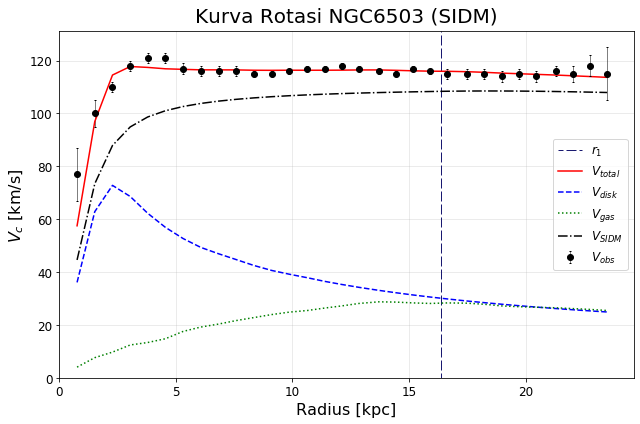

In [15]:
#Membuat plot kurva rotasi (dengan r1)
plt.figure(figsize=(9,6))
plt.axvline(x = r1, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_1$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(rad, vDM, label = '$V_{SIDM}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title(r'Kurva Rotasi {} (SIDM)'.format(rc['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xticks(fontsize=12); plt.yticks(fontsize=12) # new
plt.xlabel('Radius [kpc]', size=16)
plt.ylabel(r'$V_{c}$ [km/s]', size=16)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi {} (SIDM).jpg'.format(rc['ID'][0]), bbox_inches = 'tight', dpi = 150)
plt.show()